# Build extent-clipped (tile, basin, etc) stacks
#### used to tally and report biomass within masks (zones); eg. for landcovers
after building the extent-clipped stacks, analyze with extent_report.ipynb

In [1]:
# For some reason this is needed to get s3fs to work in ExtractUtils
# this upgrades to 0.3.4 even though we already specify this version in requirements_main...
!pip install s3fs --upgrade
!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
import s3fs
s3 = s3fs.S3FileSystem(anon=True)

  Using cached s3fs-2023.1.0-py3-none-any.whl (27 kB)
  Using cached aiobotocore-2.4.2-py3-none-any.whl (66 kB)
  Attempting uninstall: s3fs
    Found existing installation: s3fs 0.3.4
    Uninstalling s3fs-0.3.4:
      Successfully uninstalled s3fs-0.3.4
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached s3fs-0.3.4-py3-none-any.whl (18 kB)
  Attempting uninstall: s3fs
    Found existing installation: s3fs 2023.1.0
    Uninstalling s3fs-2023.1.0:
      Successfully uninstalled s3fs-2023.1.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
try:
    import geopandas as gpd
    !pip install -U plotnine
except ModuleNotFoundError:
    print('Need to pip install packages...')
    !pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt

import matplotlib
import geopandas as gpd
import pandas as pd
import rasterio
import glob
import os
#import rioxarray
import fiona
from pyproj import CRS, Transformer

import sys
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils
import CovariateUtils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio
from rasterio.plot import show_hist, show
import numpy.ma as ma
from build_stack import *

from plotnine import *
import contextily as ctx
print("Importing packages complete.")
    
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


  Using cached plotnine-0.8.0-py3-none-any.whl (4.7 MB)
  Using cached mizani-0.7.3-py3-none-any.whl (63 kB)
  Using cached descartes-1.1.0-py3-none-any.whl (5.8 kB)
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)
  Using cached statsmodels-0.13.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.9 MB)
  Using cached palettable-3.3.0-py2.py3-none-any.whl (111 kB)
  Using cached packaging-23.0-py3-none-any.whl (42 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 21.0
    Uninstalling packaging-21.0:
      Successfully uninstalled packaging-21.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Importing packages complete.


## Set up output directories, covars footprint vector, and tiles vector input

In [3]:
# a writable outdir
OUTDIR_MAIN = '/projects/my-public-bucket/analyze_agb'
OUTDIR_MASK_AGB = os.path.join(OUTDIR_MAIN, 'output_mask_agb')

# Setup access to ESA Worldcover s3 rasters
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

# ESA Worldcover v100 2020
COVAR_FOOTPRINTS_FN = os.path.join(OUTDIR_MAIN,'footprints_v100_2020_v100_2020_map-s3.gpkg')

# Get boreal tiles to use CRS for reprojecting HYDROBASINS
boreal_tiles = gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg')

https://gis.stackexchange.com/questions/345917/overlay-two-raster-geotiffs-using-rasterio-mask

##### Example: Get Worldcover covariate tiles

In [4]:
# Build a VRT of the LC on s3?
covar_footprint_tiles = gpd.read_file(COVAR_FOOTPRINTS_FN)
covar_footprint_tiles.head()

,footprint_name,path,file,s3_path,geometry
0,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E006_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((9.00000 0.00000, 9.00000 3.00000, 6...."
1,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E009_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((12.00000 0.00000, 12.00000 3.00000, ..."
2,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E012_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((15.00000 0.00000, 15.00000 3.00000, ..."
3,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E015_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((18.00000 0.00000, 18.00000 3.00000, ..."
4,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E018_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((21.00000 0.00000, 21.00000 3.00000, ..."


### Establish some broad DOMAIN in which to collect regions

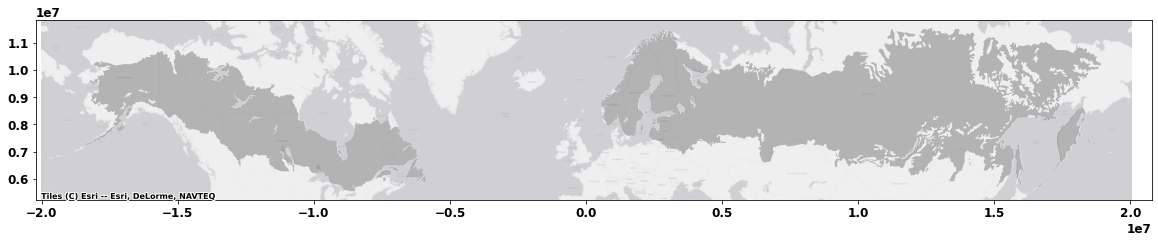

In [70]:
if False:
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres") )
    alaska = world[world.name == 'United States of America'].explode().cx[-170:-50, 50:90]
    canada = world[world.name == 'Canada']
    canada_alaska = pd.concat([alaska, canada])
    canada_alaska.plot()
    
# Get boreal domain from wwf 
boreal_gdf = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')
ax = boreal_gdf.to_crs(3857).plot(alpha=0.25, color='black', figsize=(20,5))
ctx.add_basemap(ax, source = ctx.providers.Esri.WorldGrayCanvas)

### Subset covariate tiles by broad domain (boreal)
* Build the spatial selector with 'intersects'
* do the subset accord to region (where region is identified with the spatial selector)

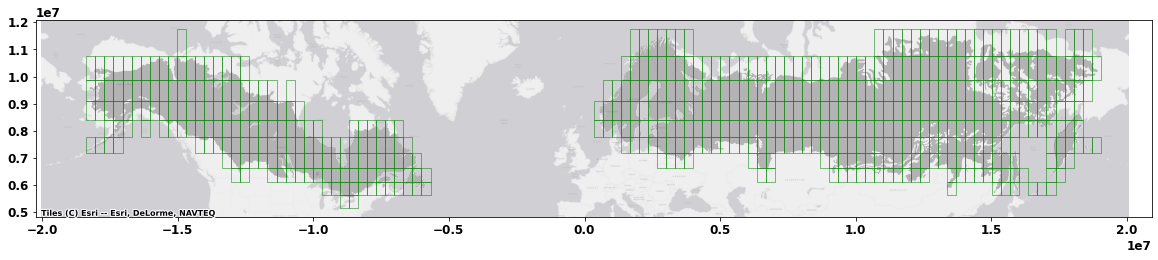

In [76]:
tile_group_region_string = 'wwf_boreal'

boreal_gdf['dissolve_field'] = 'for intersect'

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = covar_footprint_tiles.intersects(boreal_gdf.dissolve(by='dissolve_field').iloc[0].geometry)
covar_footprint_tiles_subset = covar_footprint_tiles[selector]
ax = covar_footprint_tiles_subset.to_crs(3857).boundary.plot(linewidth=0.5, color='green', figsize=(20,5))
ax = boreal_gdf.to_crs(3857).plot(alpha=0.25, color='black', ax=ax)
ctx.add_basemap(ax, source = ctx.providers.Esri.WorldGrayCanvas)

### Subset covariate tiles by sub-domain (eg, NA boreal)

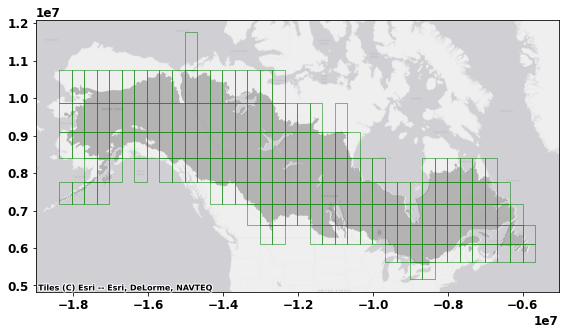

In [77]:
SUB_DOMAIN = 'america' #eurasia

tile_group_region_string = tile_group_region_string + '_' + SUB_DOMAIN

if 'america' in SUB_DOMAIN:
    xmin, xmax, ymin, ymax = [-179, -50, 30, 90]
if 'eurasia' in SUB_DOMAIN:
    xmin, xmax, ymin, ymax = [-20, 179, 30, 90]

SUB_DOMAIN_selection_geometry = boreal_gdf.cx[xmin:xmax, ymin:ymax].iloc[0].geometry

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = covar_footprint_tiles_subset.intersects(SUB_DOMAIN_selection_geometry)

covar_footprint_tiles_subset = covar_footprint_tiles_subset[selector]
ax = covar_footprint_tiles_subset.to_crs(3857).boundary.plot(linewidth=0.5, color='green', figsize=(20,5))
ax = boreal_gdf.cx[xmin:xmax, ymin:ymax].to_crs(3857).plot(alpha=0.25, color='black', ax=ax)
ctx.add_basemap(ax, source = ctx.providers.Esri.WorldGrayCanvas)

In [8]:
# cog bands dict
bands_dict = {'1': 'esa_worldcover_v100_2020'
             }

### Subset the hydrobasins by sub domain (eg, all basins in NA boreal) 
this is just one of many vector files you can clip by - just requires some prep

In [9]:
# Make GPKG of a merge all hydrobasin regions for a certain level
NORTHERN_REGION_IDS = ['ar','as','eu','na','si']
HYBAS_LEVEL_STR = 'lev06'
OUT_HYBAS_NORTHERN_FN = os.path.join(OUTDIR_MAIN, 'input_zones', f'hybas_lake_NORTHERN_{HYBAS_LEVEL_STR}_{SUB_DOMAIN}_vc1.gpkg')

if not os.path.isfile(OUT_HYBAS_NORTHERN_FN):
    print(f"Building and writing file: {OUT_HYBAS_NORTHERN_FN}")
    pd.concat([gpd.read_file(f).cx[xmin:xmax, ymin:ymax] for f in [glob.glob(f'/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_{hybas_reg}_{HYBAS_LEVEL_STR}_v1c.shp')[0] for hybas_reg in NORTHERN_REGION_IDS]]).to_file(OUT_HYBAS_NORTHERN_FN, driver='GPKG')
   # pd.concat([gpd.read_file(f) for f in glob.glob(f'/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_*_{HYBAS_LEVEL_STR}_v1c.shp')]).to_file(OUT_HYBAS_GLOBAL_FN, driver='GPKG')
print(f"{OUT_HYBAS_NORTHERN_FN}")

/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_america_vc1.gpkg


### Establish and CHOOSE the clip INDEX_FN
vector polygon regions (specific basin, LVIS flightline, tile, etc within sub-domain)
* the GPKG that holds 1 specific clip polygon

In [10]:
CLIP_INDEX_DICT_LIST = [
    # Hydrobasins
    {
        'ID_COL_NAME': 'HYBAS_ID',
        'ID': 7060157640, #3060534340, #7060157640 4070084980 #4070000010,
        'ID_NAME': HYBAS_LEVEL_STR,
        'INDEX_LYR': None,
        'INDEX_FN': OUT_HYBAS_NORTHERN_FN, #f'/projects/my-public-bucket/analyze_agb/hydrobasins/{HYBAS_FILE}.shp'
        'ADD_STR': "-" + tile_group_region_string + '-reprj',
        'INDEX_REPRJ_FN': OUT_HYBAS_NORTHERN_FN.replace('.gpkg', "-" + tile_group_region_string + '-reprj' + '.gpkg')
    },
    # LVIS flightlines
    {
        'ID_COL_NAME': 'tile_num',
        'ID': None,
        'ID_NAME': 'LVIS flightlines',
        'INDEX_LYR': 'LVISF2_2017',
        'INDEX_FN': '/projects/my-public-bucket/LVIS_ABoVE_spatial_footprints_2017_2019.gpkg',
        
        'ADD_STR': '',
        'INDEX_REPRJ_FN': ''
    },
    # Boreal tiles
    {
        'ID_COL_NAME': 'tile_num',
        'ID': 2139, #3358, #3204, #3203, #2832, #3265, #3457, #2485 , #3417, # 4253
        'ID_NAME': 'borealtiles',
        'INDEX_LYR': None, 
        'INDEX_FN': '/projects/my-public-bucket/boreal_tiles_v003.gpkg', #<---has to be writable, since the reprojected verion of this file will be written next to it
        'ADD_STR': '',
        'INDEX_REPRJ_FN': ''

    }  ,
    # Copernicus DEM tiles
    {
        'ID_COL_NAME': 'tile_num',
        'ID': 12967,
        'ID_NAME': 'DEMtiles',
        'INDEX_LYR': None,
        'INDEX_FN': '/projects/shared-buckets/lduncanson/dem30m_tiles_v2.geojson', # change the dir path to one that is writable
        'ADD_STR':'',
        'INDEX_REPRJ_FN': ''
    },
    # A user defined AOI example
    {
        'ID_COL_NAME': 'OBJECTID',
        'ID': 1,
        'ID_NAME': 'woodwell_aoi_siberia',
        'INDEX_LYR': None,
        'INDEX_FN': '/projects/my-public-bucket/analyze_agb/input_zones/woodwell_aoi_siberia.gpkg',
        'ADD_STR':'',
        'INDEX_REPRJ_FN': '/projects/my-public-bucket/analyze_agb/input_zones/woodwell_aoi_siberia-reprj.gpkg'
    },
    # Validation AOIs for North America (Alaska)
    {
        'ID_COL_NAME': 'id',
        'ID': 3,
        'ID_NAME': 'na_validation_AGB_aoi',
        'INDEX_LYR': None,
        'INDEX_FN': "/projects/shared-buckets/lduncanson/northamerica_test_data/footprints_northamerica_ref_AGB_tiles.gpkg",#"/projects/shared-buckets/tonyumd/north_america_test_data/aoi.shp",
        'ADD_STR':'',
        'INDEX_REPRJ_FN': '/projects/shared-buckets/lduncanson/northamerica_test_data/footprints_northamerica_ref_AGB_tiles-reprj.gpkg',#'/projects/my-public-bucket/analyze_agb/input_zones/north_america_test_data_aoi-reprj.gpkg' 
    },
    # Validation AOIs for Norway
    {
        'ID_COL_NAME': 'id',
        'ID': 1,
        'ID_NAME': 'norway_validation_AGB_aoi',
        'INDEX_LYR': None,
        'INDEX_FN': "/projects/shared-buckets/lduncanson/norway_test_data/footprints_norway_ref_AGB_tiles.gpkg",#"/projects/shared-buckets/tonyumd/north_america_test_data/aoi.shp",
        'ADD_STR':'',
        'INDEX_REPRJ_FN': '/projects/shared-buckets/lduncanson/norway_test_data/footprints_norway_ref_AGB_tiles-reprj.gpkg',#'/projects/my-public-bucket/analyze_agb/input_zones/north_america_test_data_aoi-reprj.gpkg' 
    }
]

# Choose SPECIFIC dictionary with clip index vector (AOI) info

In [11]:
CLIP_INDEX_DICT = CLIP_INDEX_DICT_LIST[0]
CLIP_INDEX_DICT

{'ID_COL_NAME': 'HYBAS_ID',
 'ID': 7060157640,
 'ID_NAME': 'lev06',
 'INDEX_LYR': None,
 'INDEX_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_america_vc1.gpkg',
 'ADD_STR': '-wwf_boreal_america-reprj',
 'INDEX_REPRJ_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_america_vc1-wwf_boreal_america-reprj.gpkg'}

### Read and subset the clipping INDEX vector
update string variables used in BUILD_STACK

In [12]:
print(f'Reading vector...')
#if CLIP_INDEX_DICT['ID_COL_NAME'] is not None:,
z = gpd.read_file(CLIP_INDEX_DICT['INDEX_FN'], layer=CLIP_INDEX_DICT['INDEX_LYR'])

print(f'Checking columns...')
if CLIP_INDEX_DICT['ID_COL_NAME'] not in z.columns.tolist():
    
    print('Adding column...')
    NEW_INDEX_COLUMN_NAME = 'tile_num'
    z[NEW_INDEX_COLUMN_NAME] = z.index
    CLIP_INDEX_DICT['ID_COL_NAME'] = NEW_INDEX_COLUMN_NAME
    z.to_file(CLIP_INDEX_DICT['INDEX_FN'], driver='GPKG', layer=CLIP_INDEX_DICT['INDEX_LYR'], overwrite=True)
try:
    print(f'Checking CRS units of clipping GPKG...')
    INPUT_CRS_UNITS = z.crs.axis_info[0].unit_name
except AttributeError as e:
    print(f'Assuming CRS is 4326..setting...')
    z = z.set_crs(4326)
    INPUT_CRS_UNITS = z.crs.axis_info[0].unit_name
    print(e)

print(f'Making spatial subset of clipping GPKG...')
if 'degree' not in INPUT_CRS_UNITS:
    
   # print(f'Reading...')
    #z = gpd.read_file(CLIP_INDEX_DICT['INDEX_FN'], layer=CLIP_INDEX_DICT['INDEX_LYR'])
          
    print(f'Reprojecting to 4326, then subset by sub-domain...')
    z = z.to_crs(4326)
    
#else:   
    #print(f"Reading and clipping to sub-domain simultaneously via mask on read...")
    ## Read in spatial subset to get the hydrobasin SELECTION 
    #z = gpd.read_file(CLIP_INDEX_DICT['INDEX_FN'], mask=SUB_DOMAIN_selection_geometry, layer=CLIP_INDEX_DICT['INDEX_LYR']) #
    
print("Subset by SUB_DOMAIN...")
selector = z.intersects(SUB_DOMAIN_selection_geometry)
z = z[selector]

if z.shape[0] == 0:
    print(f"\n----No features from:\n{CLIP_INDEX_DICT['INDEX_FN']}\nin sub-domain:\n{SUB_DOMAIN}")
else:
    if 'LAKE' in z.columns.tolist():
        # Remove lakes!
        z = z[z.LAKE==0]

    if 'degree' in INPUT_CRS_UNITS:

        print('Reprojecting to equal area and writing reprojected output...')
        # Reproject hydrobasin SELECTION to equal area (boreal_tiles)
        z.to_crs(boreal_tiles.crs).to_file(CLIP_INDEX_DICT['INDEX_REPRJ_FN'], driver='GPKG', layer=CLIP_INDEX_DICT['INDEX_LYR'])

        # Read and plot the basin in orig prj
        #z = gpd.read_file(INDEX_FN).to_crs(4326)

        # Now change this variable back to what BUILD_STACK_DICT wants
        # Now you have INDEX_FN in the boreal_tiles crs
        INDEX_FN = CLIP_INDEX_DICT['INDEX_REPRJ_FN']
    else:
        INDEX_FN = CLIP_INDEX_DICT['INDEX_FN']


    # The INDEX_LYR comes off the INDEX_FN set just above...
    if CLIP_INDEX_DICT['INDEX_LYR'] is None:
        print('Specify the layer name of the GPKG...')
        INDEX_LYR = os.path.split(INDEX_FN)[1].split('.gpkg')[0]
    else:
        INDEX_LYR = CLIP_INDEX_DICT['INDEX_LYR']

    print(f"\nDone updating file string input for build_stack():\n{INDEX_FN}\n{INDEX_LYR}")

Reading vector...
Checking columns...
Checking CRS units of clipping GPKG...
Making spatial subset of clipping GPKG...
Subset by SUB_DOMAIN...
Reprojecting to equal area and writing reprojected output...
Specify the layer name of the GPKG...

Done updating file string input for build_stack():
/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_america_vc1-wwf_boreal_america-reprj.gpkg
hybas_lake_NORTHERN_lev06_america_vc1-wwf_boreal_america-reprj


### Get clip extent: randomly choose a feature (polygon) to examine and plot

Variables needed for input into BUILD_CLIP_DICT:
/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_america_vc1-wwf_boreal_america-reprj.gpkg
hybas_lake_NORTHERN_lev06_america_vc1-wwf_boreal_america-reprj
HYBAS_ID
7060157640


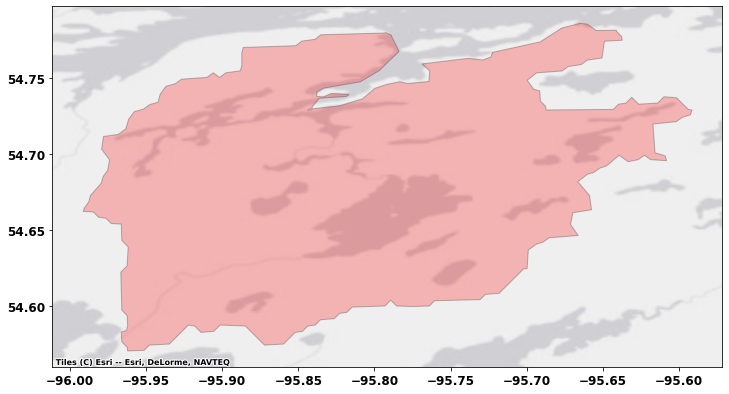

In [60]:
if CLIP_INDEX_DICT['ID'] is None:
    # Get random feature (HYBAS)
    TILE_NUM = z.sample(n=1)[CLIP_INDEX_DICT['ID_COL_NAME']].to_list()[0]
else:
    TILE_NUM = CLIP_INDEX_DICT['ID']
    

print('Variables needed for input into BUILD_CLIP_DICT:')
ID_COL_NAME = CLIP_INDEX_DICT['ID_COL_NAME']
print(INDEX_FN)
print(INDEX_LYR)
print(ID_COL_NAME)
print(TILE_NUM)

# Some extents will be near the -180 line and cause the plotting chunk to fail when doing the area calc.
# Try removing these polygons.
ax = z[ z[CLIP_INDEX_DICT['ID_COL_NAME']]==TILE_NUM  ].plot(color='red', alpha=0.25, ec='k', figsize=(12,8))
ax = ctx.add_basemap(ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas, zoom=10)
BAD_TILE_LIST = [3540,3634,3728,3823,3916,4004]

#### Plot clip extent within boreal 
This will fail if the TILE_NUM specified is NOT in the data frame

Feature ID: 7060157640
Plot boreal...
Read hydrobasins...
Write equal area extent vector to file...
Get area of basin...
Area (ha.) of feature 7060157640:		37085.07
Plot...


/opt/conda/lib/python3.7/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 16).
/opt/conda/lib/python3.7/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 29 is not valid for the current tile provider (valid zooms: 0 - 16).


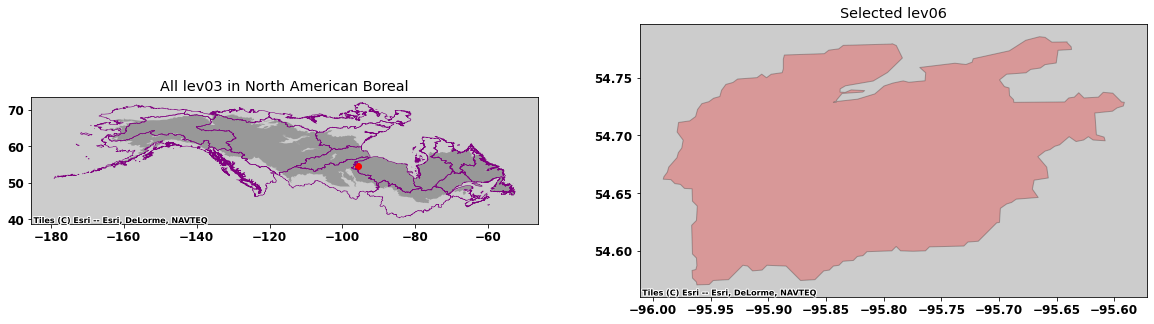

In [79]:
SHOW_FULL_EXTENT = False

print(f'Feature ID: {TILE_NUM}')

f, (ax1, ax2) = plt.subplots(figsize=(20, 25), ncols=2, nrows=1)
ALL_HYBAS_LEVEL = 'lev03'
ax1.set_title(f"All {ALL_HYBAS_LEVEL} in North American Boreal")
ax2.set_title(f"Selected {CLIP_INDEX_DICT['ID_NAME']}")

print('Plot boreal...')
boreal_gdf.cx[xmin:xmax, ymin:ymax].plot(linewidth=0.25, color='black', alpha=0.25, marker = '---', ax = ax1)

print('Read hydrobasins...')
# Read in hydrobasins in bbox
hybas_border = gpd.read_file(f'/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_{ALL_HYBAS_LEVEL}_vc1.gpkg', bbox=(xmin, ymin, xmax, ymax))
# Clip hydrobasins to sub domain; plot
hybas_border[hybas_border.intersects(SUB_DOMAIN_selection_geometry)].boundary.plot(linewidth=0.5, color='purple', ax = ax1)

if SHOW_FULL_EXTENT:
    z.plot(color=None, linewidth=0.1, ax=ax1)
else:
    z[( z[CLIP_INDEX_DICT['ID_COL_NAME']]==TILE_NUM) ].boundary.plot(color='red', linewidth=1, ax=ax1)
    
print('Write equal area extent vector to file...')
extent_gdf_fn = f"/projects/my-public-bucket/analyze_agb/output_mask_agb/extent_{TILE_NUM}_{CLIP_INDEX_DICT['ID_NAME']}.gpkg"
EXTENT_gdf = z[( z[CLIP_INDEX_DICT['ID_COL_NAME']]==TILE_NUM) ].to_crs(boreal_tiles.crs)
EXTENT_gdf.to_file(extent_gdf_fn, driver='GPKG')

print('Get area of basin...')
basin_area_ha = EXTENT_gdf.area.to_list()[0] / 1e4
print(f"Area (ha.) of feature {TILE_NUM}:\t\t{round(basin_area_ha,2)}")

print('Plot...')
z[z[CLIP_INDEX_DICT['ID_COL_NAME']]==TILE_NUM].to_crs(boreal_tiles.crs).centroid.to_crs(4326).plot(color='red', ax = ax1)
z[z[CLIP_INDEX_DICT['ID_COL_NAME']]==TILE_NUM].to_crs(boreal_tiles.crs).to_crs(4326).plot(color='red', alpha=0.25, ec='k', ax = ax2)

ax1 = ctx.add_basemap(ax1, source = ctx.providers.Esri.WorldGrayCanvas)
ax2 = ctx.add_basemap(ax2, source = ctx.providers.Esri.WorldGrayCanvas)

# Set list of dictionary inputs to stack
## Setup input using hydrobasin as clip INDEX_FN
* reprojected to equal area using boreal_tile_index
* so output has same res, crs, and clip extent

In [62]:
#BUILD_STACK_DICT = {'INDEX_FN':INDEX_FN,'ID_COL_NAME':ID_COL_NAME,'TILE_NUM':TILE_NUM,'INDEX_LYR':INDEX_LYR,'RASTER_NAME':'','COVAR_TILE_FN':'', 'IN_COVAR_S3_COL':'', 'NODATA_VAL':''}
DEFAULT_BUILD_STACK_DICT_LIST = [
    # ESA Worldcover 2020
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # Worldcover data is accessed via its footprint, with a 's3_path' col identifying the s3 locations of each tile
            'RASTER_NAME': 'esa_worldcover_v100_2020',
            'COVAR_TILE_FN': '/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 0,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        },
        # Boreal Biomass c2020 (final)
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # AGB data is accessed
            # This needs to be correctly in 4326 - 
            'RASTER_NAME': 'biomass_final',
            'COVAR_TILE_FN': '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master.json',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': -9999,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        },
    # Boreal Stand Age 2020
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
            'RASTER_NAME': 'standage',
            'COVAR_TILE_FN': '/projects/my-public-bucket/analyze_agb/footprints_terrapulse-pub-data_forest_age_v2-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 255,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
        },
    # Boreal TCC 2020
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
            'RASTER_NAME': 'tcc2020',
            'COVAR_TILE_FN': '/projects/my-public-bucket/analyze_agb/footprints_terrapulse-pub-data_tcc_2020-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 255,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
        },
    # Boreal TCC rate of change (linear), 1984-2020
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
            'RASTER_NAME': 'tccslope',
            'COVAR_TILE_FN': '/projects/my-public-bucket/analyze_agb/footprints_terrapulse-pub-data_tcc_slope-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 255,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
        },
    # Boreal TCC rate of change (linear) p-value, 1984-2020
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
            'RASTER_NAME': 'tccpvalue',
            'COVAR_TILE_FN': '/projects/my-public-bucket/analyze_agb/footprints_terrapulse-pub-data_tcc_pvalue-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 255,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
        }
]


MISC_BUILD_STACK_DICT_LIST = [
    # Reference AGB tiles in NA: '/projects/my-public-bucket/northamerica_test_data/footprints_northamerica_ref_AGB_tiles.gpkg'
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # AGB data is accessed
            # This needs to be correctly in 4326 - 
            'RASTER_NAME': 'norway_ref_AGB',#'northamerica_ref_AGB',
            'COVAR_TILE_FN': '/projects/shared-buckets/lduncanson/norway_test_data/footprints_norway_ref_AGB_tiles.gpkg',
            'IN_COVAR_S3_COL': 'local_path',
            'NODATA_VAL': -9999,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        },
    # Boreal Height 2020 noground (winter 2022-2023)
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # AGB data is accessed
            # This needs to be correctly in 4326 - 
            'RASTER_NAME': 'boreal_ht_noground',
            'COVAR_TILE_FN': '/projects/my-public-bucket/DPS_tile_lists/HT/winter2023/map_boreal_2022_rh_noground_v1/HT_tindex_master.json',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': -9999,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        },
    # Boreal Height 2020 using ground photons (winter 2022-2023)
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # AGB data is accessed
            # This needs to be correctly in 4326 - 
            'RASTER_NAME': 'boreal_ht_ground',
            'COVAR_TILE_FN': '/projects/my-public-bucket/DPS_tile_lists/HT/winter2023/map_boreal_2022_rh_ground_v1/HT_tindex_master.json',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': -9999,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        },
    # Boreal AGB 2020 noground (winter 2022-2023)
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # AGB data is accessed
            # This needs to be correctly in 4326 - 
            'RASTER_NAME': 'boreal_agb_noground',
            'COVAR_TILE_FN': '/projects/my-public-bucket/DPS_tile_lists/AGB/winter2023/map_boreal_2022_rh_noground_v1/AGB_tindex_master.json',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': -9999,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        },
    # Boreal AGB 2020 using ground photons (winter 2022-2023)
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # AGB data is accessed
            # This needs to be correctly in 4326 - 
            'RASTER_NAME': 'boreal_agb_ground',
            'COVAR_TILE_FN': '/projects/my-public-bucket/DPS_tile_lists/AGB/winter2023/map_boreal_2022_rh_ground_v1/AGB_tindex_master.json',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': -9999,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        },
#     # Boreal Biomass 2020 (prelim, fall 2021)
#         {
#             'INDEX_FN':INDEX_FN,
#             'ID_COL_NAME':ID_COL_NAME,
#             'TILE_NUM':TILE_NUM,
#             'INDEX_LYR':INDEX_LYR,
#             # AGB data is accessed
#             # This needs to be correctly in 4326 - 
#             'RASTER_NAME': 'biomass_prelim',
#             'COVAR_TILE_FN': '/projects/shared-buckets/lduncanson/DPS_tile_lists/AGB_tindex_master.json',
#             'IN_COVAR_S3_COL': 's3',
#             'NODATA_VAL': -9999,
#             'OUTPUT_CLIP_COG_FN':'',
#             'CREDENTIALS_FN': None
#         },
    # Boreal Biomass 2020 (v2, spring 2022)
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # AGB data is accessed
            # This needs to be correctly in 4326 - 
            'RASTER_NAME': 'biomass_v2',
            'COVAR_TILE_FN': '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/v2/AGB_tindex_master.json',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': -9999,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        },

]

DEFAULT_BUILD_STACK_DICT_LIST[1]

{'INDEX_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_america_vc1-wwf_boreal_america-reprj.gpkg',
 'ID_COL_NAME': 'HYBAS_ID',
 'TILE_NUM': 7060157640,
 'INDEX_LYR': 'hybas_lake_NORTHERN_lev06_america_vc1-wwf_boreal_america-reprj',
 'RASTER_NAME': 'biomass_final',
 'COVAR_TILE_FN': '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master.json',
 'IN_COVAR_S3_COL': 's3_path',
 'NODATA_VAL': -9999,
 'OUTPUT_CLIP_COG_FN': '',
 'CREDENTIALS_FN': None}

# Choose layers for stack

In [63]:
BUILD_STACK_DICT_LIST = DEFAULT_BUILD_STACK_DICT_LIST

In [64]:
# Make an 's3_path' column and save gpkg
#c = gpd.read_file('/projects/my-public-bucket/analyze_agb/footprints_terrapulse-pub-data_tcc_pvalue.gpkg')
#c['s3_path'] = c['path'] +'/'+ c['file'] 
#c.to_file('/projects/my-public-bucket/analyze_agb/footprints_terrapulse-pub-data_tcc_pvalue-s3.gpkg', driver='GPKG')

## Run the extent clips of the rasters
run build_stack.py (now featuring a geom clip!) for all specified rasters  
Return extent clip COGs for all data sources in BUILD_STACK_DICT_LIST (loop)

In [65]:
# import importlib
# from build_stack import *

In [66]:
for BUILD_STACK_DICT in BUILD_STACK_DICT_LIST:
    
    if False:
        # --Special temporary case
        # Uh oh, any mosiac json needs to have the correct projection set
        # TODO: fix the setting of the MosaicJson in 3_DPS_review_pmm_v3
        if BUILD_STACK_DICT['RASTER_NAME'] == 'biomass_prelim':

            x = gpd.read_file(COVAR_TILE_FN)
            print('Reset projection and reproject...')
            x = x.set_crs(boreal_tiles.crs, allow_override=True, inplace=True).to_crs(4326)

            # Write a new JSON that should have the prj set correctly in 4326
            COVAR_TILE_FN = os.path.join('/projects/my-public-bucket/analyze_agb' , os.path.split(COVAR_TILE_FN)[1])
            print(COVAR_TILE_FN)
            x.to_file(COVAR_TILE_FN, driver='GeoJSON', overwrite=True)

            ## Verify 4326
            #ax = x.plot()
            #z[z[ID_COL_NAME]==TILE_NUM].to_crs(4326).plot(color='red', ax=ax)

    # INDEX clip shapes should be in equal area
    # COVAR_TILE_FN tiles (of raster COGs) should be in 4326
    args = f"\
    --in_tile_fn {BUILD_STACK_DICT['INDEX_FN']} \
    --in_tile_id_col {BUILD_STACK_DICT['ID_COL_NAME']} \
    --in_tile_num {BUILD_STACK_DICT['TILE_NUM']} \
    --tile_buffer_m 0 \
    --in_tile_layer {BUILD_STACK_DICT['INDEX_LYR']} \
    -o {OUTDIR_MASK_AGB} \
    --topo_off \
    --covar_src_name {BUILD_STACK_DICT['RASTER_NAME']} \
    --covar_tile_fn {BUILD_STACK_DICT['COVAR_TILE_FN']} \
    --in_covar_s3_col {BUILD_STACK_DICT['IN_COVAR_S3_COL']} \
    --input_nodata_value {BUILD_STACK_DICT['NODATA_VAL']} \
    --clip" #<-- testing a clip to polygon
    
    BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN'] = os.path.join( OUTDIR_MASK_AGB, f"{BUILD_STACK_DICT['RASTER_NAME']}_{BUILD_STACK_DICT['TILE_NUM']}_cog.tif")
    
    print(args,'\n')
    
    def run_build_stack():
        build_stack_(
            stack_tile_fn = BUILD_STACK_DICT['INDEX_FN'], 
            in_tile_id_col = BUILD_STACK_DICT['ID_COL_NAME'], 
            stack_tile_id = BUILD_STACK_DICT['TILE_NUM'],
            tile_buffer_m = 0, 
            stack_tile_layer = BUILD_STACK_DICT['INDEX_LYR'],
            covar_tile_fn = BUILD_STACK_DICT['COVAR_TILE_FN'],
            in_covar_s3_col = BUILD_STACK_DICT['IN_COVAR_S3_COL'], 
            res = 30, 
            input_nodata_value = BUILD_STACK_DICT['NODATA_VAL'],
            tmp_out_path = '/projects/tmp', 
            covar_src_name = BUILD_STACK_DICT['RASTER_NAME'],
            clip = True, 
            topo_off = True, 
            output_dir = OUTDIR_MASK_AGB,
            height = None,
            width = None
           )
    if True:
        # Try without setting up an aws_session
        run_build_stack()
    else:
        if BUILD_STACK_DICT['CREDENTIALS_FN'] is not None:
            aws_session = CovariateUtils.get_rio_aws_session_from_creds(BUILD_STACK_DICT['CREDENTIALS_FN'])
            with rio.Env(aws_session):
                #!python /projects/Developer/icesat2_boreal/lib/build_stack.py $args
                run_build_stack()
        else:
            #!python /projects/Developer/icesat2_boreal/lib/build_stack.py $args
            run_build_stack()

    --in_tile_fn /projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_america_vc1-wwf_boreal_america-reprj.gpkg     --in_tile_id_col HYBAS_ID     --in_tile_num 7060157640     --tile_buffer_m 0     --in_tile_layer hybas_lake_NORTHERN_lev06_america_vc1-wwf_boreal_america-reprj     -o /projects/my-public-bucket/analyze_agb/output_mask_agb     --topo_off     --covar_src_name esa_worldcover_v100_2020     --covar_tile_fn /projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg     --in_covar_s3_col s3_path     --input_nodata_value 0     --clip 

The covariate's filename(s) intersecting the 0 m buffered bbox for tile id 7060157640:
 s3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N54W096_Map.tif
in_bbox: [4067117.7888277615, 4558708.138273753, 4088443.193903968, 4586811.806507512]
Getting output height and width from buffered (buffer=0) original tile geometry...
936 x 710


/projects/Developer/icesat2_boreal/lib/build_stack.py:104: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/2a70e1ff-12e2-4161-9a07-1825b28f203d/2a70e1ff-12e2-4161-9a07-1825b28f203d.tif)' mode='r'>
Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/analyze_agb/output_mask_agb/esa_worldcover_v100_2020_7060157640_cog.tif


Writing stack as cloud-optimized geotiff: /projects/my-public-bucket/analyze_agb/output_mask_agb/esa_worldcover_v100_2020_7060157640_cog.tif
Clipping to feature polygon...
Orig stack shape:		 (1, 936, 710)
Output resolution:		 (30, 30)
Writing img to memory...
{'driver': 'VRT', 'dtype': 'uint8', 'nodata': 0, 'width': 711, 'height': 937, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 4067117.7888277615,
       0.0, -30.0, 4586811.806507512), 'blockxsize': 512, 'blockysize': 128, 'tiled': Tr

/projects/Developer/icesat2_boreal/lib/build_stack.py:104: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/a2bed451-f4bb-4bb1-a364-16a8ea4da1ca/a2bed451-f4bb-4bb1-a364-16a8ea4da1ca.tif)' mode='r'>
Adding overviews...
Updating dataset tags...


Writing stack as cloud-optimized geotiff: /projects/my-public-bucket/analyze_agb/output_mask_agb/biomass_final_7060157640_cog.tif
Clipping to feature polygon...
Orig stack shape:		 (2, 936, 710)
Output resolution:		 (30, 30)
Writing img to memory...
{'driver': 'VRT', 'dtype': 'float64', 'nodata': -9999, 'width': 711, 'height': 937, 'count': 2, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 4067117.7888277615,
       0.0, -30.0, 4586811.806507512), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}


Writing output to: /projects/my-public-bucket/analyze_agb/output_mask_agb/biomass_final_7060157640_cog.tif


Image written to disk:		 /projects/my-public-bucket/analyze_agb/output_mask_agb/biomass_final_7060157640_cog.tif
    --in_tile_fn /projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_america_vc1-wwf_boreal_america-reprj.gpkg     --in_tile_id_col HYBAS_ID     --in_tile_num 7060157640     --tile_buffer_m 0     --in_tile_layer hybas_lake_NORTHERN_lev06_america_vc1-wwf_boreal_america-reprj     -o /projects/my-public-bucket/analyze_agb/output_mask_agb     --topo_off     --covar_src_name standage     --covar_tile_fn /projects/my-public-bucket/analyze_agb/footprints_terrapulse-pub-data_forest_age_v2-s3.gpkg     --in_covar_s3_col s3_path     --input_nodata_value 255     --clip 

The covariate's filename(s) intersecting the 0 m buffered bbox for tile id 7060157640:
 s3://terrapulse-pub-data/boreal-forest-data/forest_age/data/098W/55N/098W_55N/098W_55N_forest_age.tif
in_bbox: [4067117.7888277615, 4558708.138273753, 4088443.193903968, 4586811.806507512]
Getting output heig

/opt/conda/lib/python3.7/site-packages/rio_tiler/io/cogeo.py:117: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
/projects/Developer/icesat2_boreal/lib/build_stack.py:104: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/4e212816-35c4-4e32-b018-7d27d42bc269/4e212816-35c4-4e32-b018-7d27d42bc269.tif)' mode='r'>
Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/analyze_agb/output_mask_agb/standage_7060157640_cog.tif


Writing stack as cloud-optimized geotiff: /projects/my-public-bucket/analyze_agb/output_mask_agb/standage_7060157640_cog.tif
Clipping to feature polygon...
Orig stack shape:		 (1, 936, 710)
Output resolution:		 (30, 30)
Writing img to memory...
{'driver': 'VRT', 'dtype': 'uint8', 'nodata': 255, 'width': 711, 'height': 937, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 4067117.7888277615,
       0.0, -30.0, 4586811.806507512), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}
Image writ

/opt/conda/lib/python3.7/site-packages/rio_tiler/io/cogeo.py:117: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
/projects/Developer/icesat2_boreal/lib/build_stack.py:104: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/f204f180-6be4-4f00-a039-c4dbdb52213b/f204f180-6be4-4f00-a039-c4dbdb52213b.tif)' mode='r'>
Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/analyze_agb/output_mask_agb/tcc2020_7060157640_cog.tif


Writing stack as cloud-optimized geotiff: /projects/my-public-bucket/analyze_agb/output_mask_agb/tcc2020_7060157640_cog.tif
Clipping to feature polygon...
Orig stack shape:		 (1, 936, 710)
Output resolution:		 (30, 30)
Writing img to memory...
{'driver': 'VRT', 'dtype': 'uint8', 'nodata': 255, 'width': 711, 'height': 937, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 4067117.7888277615,
       0.0, -30.0, 4586811.806507512), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}
Image writt

/opt/conda/lib/python3.7/site-packages/rio_tiler/io/cogeo.py:117: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
/projects/Developer/icesat2_boreal/lib/build_stack.py:104: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/ad5a4e54-9bbe-4b96-84a0-f8ec9c96d9e9/ad5a4e54-9bbe-4b96-84a0-f8ec9c96d9e9.tif)' mode='r'>
Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/analyze_agb/output_mask_agb/tccslope_7060157640_cog.tif


Writing stack as cloud-optimized geotiff: /projects/my-public-bucket/analyze_agb/output_mask_agb/tccslope_7060157640_cog.tif
Clipping to feature polygon...
Orig stack shape:		 (1, 936, 710)
Output resolution:		 (30, 30)
Writing img to memory...
{'driver': 'VRT', 'dtype': 'float32', 'nodata': 255, 'width': 711, 'height': 937, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 4067117.7888277615,
       0.0, -30.0, 4586811.806507512), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}
Image wr

/opt/conda/lib/python3.7/site-packages/rio_tiler/io/cogeo.py:117: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
/projects/Developer/icesat2_boreal/lib/build_stack.py:104: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/68a82ba9-41ea-4657-9f62-02aec83777f0/68a82ba9-41ea-4657-9f62-02aec83777f0.tif)' mode='r'>
Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/analyze_agb/output_mask_agb/tccpvalue_7060157640_cog.tif


Writing stack as cloud-optimized geotiff: /projects/my-public-bucket/analyze_agb/output_mask_agb/tccpvalue_7060157640_cog.tif
Clipping to feature polygon...
Orig stack shape:		 (1, 936, 710)
Output resolution:		 (30, 30)
Writing img to memory...
{'driver': 'VRT', 'dtype': 'float32', 'nodata': 255, 'width': 711, 'height': 937, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 4067117.7888277615,
       0.0, -30.0, 4586811.806507512), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}
Image w

In [ ]:
# covar_tile_fn = '/projects/shared-buckets/lduncanson/northamerica_test_data/footprints_northamerica_ref_AGB_tiles.gpkg'
# covar_tiles = gpd.read_file(covar_tile_fn)
# covar_tiles

In [ ]:
# stack_tile_fn = '/projects/shared-buckets/lduncanson/northamerica_test_data/footprints_northamerica_ref_AGB_tiles-reprj.gpkg'
# tile_buffer_m = 0
# stack_tile_id = 1
# in_tile_id_col = 'id'
# in_covar_s3_col = 'local_path'


# stack_tile_layer = 'footprints_northamerica_ref_AGB_tiles-reprj' #BUILD_STACK_DICT['INDEX_LYR']
# tile_parts = get_index_tile(vector_path=stack_tile_fn, id_col=in_tile_id_col, tile_id=stack_tile_id, buffer=tile_buffer_m, layer=stack_tile_layer)
# geom_4326_buffered = tile_parts["geom_4326_buffered"]
# # Read the covar_tiles index file
# covar_tiles = gpd.read_file(covar_tile_fn)#.to_crs(4326)

# # intersect with the bbox tile
# covar_tiles_selection = covar_tiles.loc[covar_tiles.intersects(geom_4326_buffered.iloc[0])]

# # Get the s3 urls to the granules
# file_s3 = covar_tiles_selection[in_covar_s3_col].to_list()
# file_s3.sort()
# print("The covariate's filename(s) intersecting the {} m buffered bbox for tile id {}:\n".format(str(tile_buffer_m), str(stack_tile_id)), '\n'.join(file_s3))


# Update and print the dictionary of output rasters COGs clipped to extent
use this dictionary to read in the data create an extent report (map, plot, etc)

In [67]:
# For each clip INDEX (polygon) there are 2 corresponding output clipped COGs you need
BASIN_COG_DICT = {'landcover_cog_fn': '', 'biomass_cog_fn':'', 'standage_cog_fn':'', 'extent_gdf_fn': extent_gdf_fn}

for BUILD_STACK_DICT in BUILD_STACK_DICT_LIST:
    if 'worldcover' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'landcover_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'biomass' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'biomass_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'standage' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'standage_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'tcc2020' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'tcc2020_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'tccslope' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'tccslope_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'tccpvalue' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'tccpvalue_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
BASIN_COG_DICT

{'landcover_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/esa_worldcover_v100_2020_7060157640_cog.tif',
 'biomass_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/biomass_final_7060157640_cog.tif',
 'standage_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/standage_7060157640_cog.tif',
 'extent_gdf_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/extent_7060157640_lev06.gpkg',
 'tcc2020_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/tcc2020_7060157640_cog.tif',
 'tccslope_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/tccslope_7060157640_cog.tif',
 'tccpvalue_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/tccpvalue_7060157640_cog.tif'}

# BELOW HAS BEEN MOVE TO ANOTHER NOTEBOOK
extent_report.ipynb

### Replace the tile or basin ID in the current dict with any already run

In [177]:
FOCAL_EXTENT_ID = 2485
for key, value in BASIN_COG_DICT.items():
    BASIN_COG_DICT[key] = value.replace(value.split('_')[-2], str(FOCAL_EXTENT_ID))
    #print(value.split('_')[-2])
BASIN_COG_DICT

{'landcover_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/esa_worldcover_v100_2020_2485_cog.tif',
 'biomass_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/biomass_v2_2485_cog.tif',
 'standage_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/standage_2485_cog.tif',
 'extent_gdf_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/extent_2485_3457.gpkg',
 'tcc2020_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/tcc2020_2485_cog.tif',
 'tccslope_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/tccslope_2485_cog.tif',
 'tccpvalue_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/tccpvalue_2485_cog.tif'}

# Create extent report
### Open clipped Worldcover COG and corresponding AGB, loop over LC classes, masking, summing, etc


Area (ha.) of extent 3457:		810000.0000000692

lc_arr shape: (3000, 3000)
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 3000, 'height': 3000, 'count': 2, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, -3231478.0000000047,
       0.0, -30.0, 4113304.0000000093), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}
agb nodata value: None
agb_arr shape: (3000, 3000)

0 Trees 10
	# land cov 

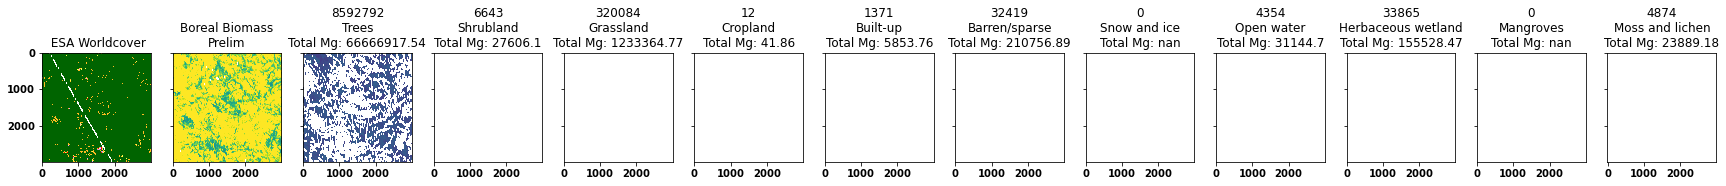

In [153]:
## %%time

# The area in hectares of a 30m pixel
area_pix_ha = 0.09

# The land cover values in which you want to summarize AGB
values_worldcover = [10,20,30,40,\
                     50,\
                     60,70,80,90,95,100] #'Trees', 'Shrubland', 'Grassland','Cropland', 'Barren / sparse vegetation', 'Herbaceous wetland','Moss and lichen'

fig, axes = plt.subplots(nrows=1, ncols=len(values_worldcover)+2, figsize=(30,10), sharex=True, sharey=True)

# Read back in the topo_stack_cog_fn and plot

with rasterio.open(BASIN_COG_DICT['landcover_cog_fn']) as dataset:
    
    lc_meta = dataset.profile
    
    print(f"\nArea (ha.) of extent {TILE_NUM}:\t\t{basin_area_ha}")
    
    lc_arr = dataset.read(1)
    print(f"\nlc_arr shape: {lc_arr.shape}")
    
    # NoData value is 0; mask this
    lc_arr = np.ma.masked_where( lc_arr == 0, lc_arr)
    
    # Plotting
    names_worldcover = [ 'Trees', 'Shrubland', 'Grassland','Cropland',\
                        'Built-up',
                        'Barren/sparse','Snow and ice','Open water','Herbaceous wetland','Mangroves','Moss and lichen']
    cols_worldcover = [ "#006400","#ffbb22","#ffff4c","#f096ff",\
                       "#fa0000",\
                       "#b4b4b4","#f0f0f0","#0064c8","#0096a0","#00cf75","#fae6a0"]
    #cols_worldcover = ["white","green","orange","yellow","purple","red","brown","gray","blue","pink","cyan","black"]
    #cols_mask = ["white", "red"]
    #values_mask = [0,1]

    cmap_worldcover = ListedColormap(cols_worldcover)
    norm_worldcover = BoundaryNorm(values_worldcover, len(cols_worldcover))

    #cmap_masked = ListedColormap(cols_mask)
    #norm_masked= BoundaryNorm(values_mask, len(cols_mask))
    
    axes[0].imshow(lc_arr, cmap=cmap_worldcover, norm=norm_worldcover)
    axes[0].set_title(f" ESA Worldcover")
    
    # Find sum of AGB per LC class
    # multiply by AGB values and sum
    with rasterio.open(BASIN_COG_DICT['biomass_cog_fn']) as dataset_agb:
        
        print(dataset_agb.profile)
        
        agb_arr = dataset_agb.read(1)
        print(f"agb nodata value: {dataset_agb.nodata}")
        
        #agb_arr = np.ma.masked_where( (lc_arr==0) | (agb_arr<0), agb_arr)
        agb_arr = np.ma.masked_where(  (agb_arr<0), agb_arr)
        total_mg_all = np.nansum(agb_arr)
        
        print(f"agb_arr shape: {agb_arr.shape}\n")
        axes[1].imshow(agb_arr, clim=(0,75))
        axes[1].set_title(f"Boreal Biomass\nPrelim")
    
        for i, LC_VALUE in enumerate(values_worldcover):
        #for i, LC_VALUE in enumerate([v for v in LC_VAL_LIST if v in values_worldcover ]):

            LC_NAME = names_worldcover[i]
            print(i, LC_NAME, LC_VALUE)

            # For LC value of interest
            #lc_agb_arr = np.ma.masked_where( (lc_arr == 0) | (agb_arr < 0) | (lc_arr != LC_VALUE) , agb_arr)
            lc_agb_arr = np.ma.masked_where( (lc_arr != LC_VALUE) , agb_arr)
            
            num_lc_pixels_in_mask = lc_agb_arr[~np.isnan(lc_agb_arr)].count() 
            num_lc_pixels_in_mask = lc_agb_arr.count()
            total_lc_area_ha = num_lc_pixels_in_mask * area_pix_ha
            
            print(f"\t# land cov pixels in class:\t\t\t{num_lc_pixels_in_mask}")
            print(f"\t# Total area (ha.) in class:\t\t\t{total_lc_area_ha} ({round(100 * total_lc_area_ha / basin_area_ha,2)}% of extent)")
            
            total_mg_lc = np.nan
            
            if False and LC_VALUE == 40:
                list_of_vals = lc_agb_arr[lc_agb_arr.mask == False].tolist()
                print(list_of_vals)
                #print(f"\t\t{(sum(list_of_vals) / num_lc_pixels_in_mask) * area_pix_ha}")
                
            if LC_VALUE == 10:
                trees_lc_agb_arr = lc_agb_arr
            
            if num_lc_pixels_in_mask > 0:
                
                print(f"\tMg/ha (min,mean,med,max):\t\t\t\t{round(np.nanmin(lc_agb_arr),2)}, {round(np.nanmean(lc_agb_arr),2)}, {round(np.ma.median(lc_agb_arr),2)} , {round(np.nanmax(lc_agb_arr),2)}")

                # ***To get error bars on total (Mg), need to have mean AGB raster and sd AGB raster, and use them to sample a normal distribution of AGB values per pixel, n=100 times per pixel?
                # Then get all the totals from the n layers, and get the mean total and the sd of the total
                #total_mg_lc = (lc_agb_arr.sum() / num_lc_pixels_in_mask) * area_pix_ha
                total_mg_lc = np.nansum(lc_agb_arr * area_pix_ha)
                print(f"\tTotal AGB (Mg) in class:\t\t\t{round( total_mg_lc, 2)} ({round(100 * total_mg_lc / total_mg_all,2)}% of extent biomass)")
            
            # To plot with a legend: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/
            axes[i+2].imshow(lc_agb_arr, clim=(-100,700))
            axes[i+2].set_title(f"{num_lc_pixels_in_mask}\n{LC_NAME}\nTotal Mg: {round(total_mg_lc,2)}")
            
            #show(lc_mask, cmap=cmap_masked, norm=norm_masked)
            #show_hist(lc_mask, bins=len(values_masked)+1, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram of ESA Worldcover Class Values")

In [154]:
!pip install -U matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar
def add_colorbar(mappable, label):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.set_label(label)
    plt.sca(last_axes)
    return cbar



You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## Map biomass for Tree extents
The extent of 'trees' in the ESA Worldcover v1 2020 land cover dataset provides an independent mask to sum biomass for each polygon

Extent:		3457
Total ha.:		809271.09
Mean Mg/ha:		84.43
Total Pg.:		0.0683
Mean Mg/ha in trees:	86.21
Total Pg. in trees:	0.0667


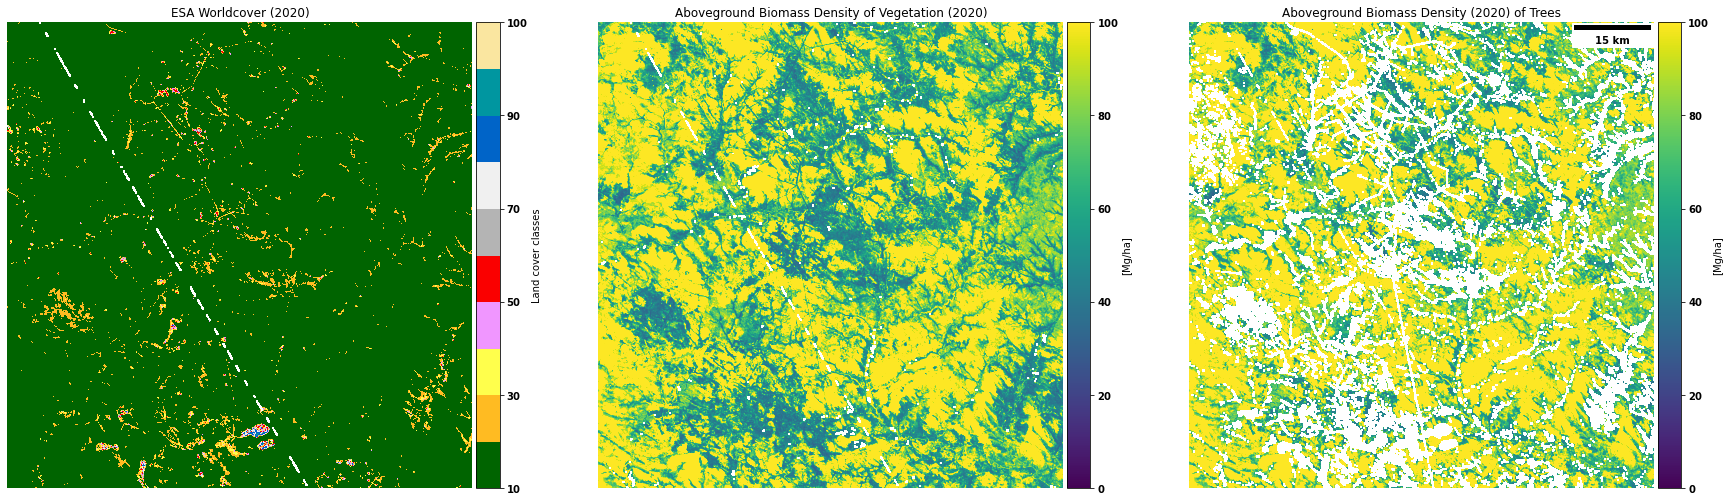

In [155]:
LC_VAL = 10
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,30), sharex=True, sharey=True)

# Scalebar doesnt seem correct
scalebar = ScaleBar(30) # <-- each pixel (unit) is 30m
plt.gca().add_artist(scalebar)

# AGB arrays
# With a water mask
agb_arr_masked = np.ma.masked_where( (lc_arr == 0  ) | (lc_arr == 80) , agb_arr)

# Without a water mask
#agb_arr_masked = np.ma.masked_where( (lc_arr == 0  )  ,agb_arr)

# AGB density of ESA Worldcover v1 2020 trees 
agb_arr_masked_trees = np.ma.masked_where( (lc_arr != LC_VAL  ), agb_arr_masked)

print(f"Extent:\t\t{TILE_NUM}")
print(f"Total ha.:\t\t{(agb_arr_masked[~np.isnan(agb_arr_masked)].count() * area_pix_ha ) }")
print(f"Mean Mg/ha:\t\t{ round(np.nanmean(agb_arr_masked),2) }")
print(f"Total Pg.:\t\t{round(np.nansum(agb_arr_masked)/1e9 * area_pix_ha,4) }")
print(f"Mean Mg/ha in trees:\t{ round(np.nanmean(agb_arr_masked_trees),2) }")
print(f"Total Pg. in trees:\t{round(np.nansum(agb_arr_masked_trees)/1e9 * area_pix_ha, 4) }")

# Plots

# Showing only trees LC
#m2 = axes[1].imshow(lc_arr_trees, cmap=cmap_worldcover, norm=norm_worldcover)
# Showing all LC classes
m1 = axes[0].imshow(lc_arr, cmap=cmap_worldcover, norm=norm_worldcover)
add_colorbar(m1, 'Land cover classes')
axes[0].set_title('ESA Worldcover (2020)')
axes[0].axis('off')

m2 = axes[1].imshow(agb_arr_masked, clim=(0,100) )
add_colorbar(m2, '[Mg/ha]')
m2 = axes[1].set_title('Aboveground Biomass Density of Vegetation (2020)')
axes[1].axis('off')

# Show AGB for tree
m3 = axes[2].imshow(agb_arr_masked_trees, clim=(0,100), cmap='viridis')
add_colorbar(m3, '[Mg/ha]')
m3 = axes[2].set_title('Aboveground Biomass Density (2020) of Trees')
axes[2].axis('off')

if False:
    # Convert AGB density to total
    m4 = axes[3].imshow(agb_arr_masked_trees* area_pix_ha, clim=(0,10), cmap='plasma')
    add_colorbar(m3, '[Mg]')
    m4 = axes[3].set_title('Aboveground Biomass (2020) of Trees')
    axes[3].axis('off')

## Write Tree AGB

In [156]:
# Stack
# move axis of the stack so bands is first
# LC array (int) mask filled with 0 .... AGB arrays (floats) filled with nan
analysis_stack = np.stack([lc_arr.filled(0) , agb_arr_masked.filled(np.nan) , agb_arr_masked_trees.filled(np.nan) ])
analysis_stack_names = ["lc", "agb", "agb_tree"]

# Copy input agb metadata
out_meta = dataset_agb.profile
out_meta

# write COG to disk
write_cog(
            analysis_stack, 
            os.path.splitext(BASIN_COG_DICT['biomass_cog_fn'])[0] + "_ESA_trees.tif", 
            out_meta['crs'], 
            out_meta['transform'], 
            analysis_stack_names, 
            out_crs=out_meta['crs']
             )

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/469d8b23-2d40-421a-998d-c824e258d53c/469d8b23-2d40-421a-998d-c824e258d53c.tif)' mode='r'>


Input nodata isnt provided; assuming NaN...
Orig stack shape:		 (3, 3000, 3000)
Output resolution:		 (30, 30)
Writing img to memory...
{'driver': 'VRT', 'dtype': 'float64', 'nodata': nan, 'width': 3000, 'height': 3000, 'count': 3, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, -3231478.0000000047,
       0.0, -30.0, 4113304.0000000093), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}


Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/analyze_agb/output_mask_agb/biomass_v2_2485_cog_ESA_trees.tif


Image written to disk:		 /projects/my-public-bucket/analyze_agb/output_mask_agb/biomass_v2_2485_cog_ESA_trees.tif


True

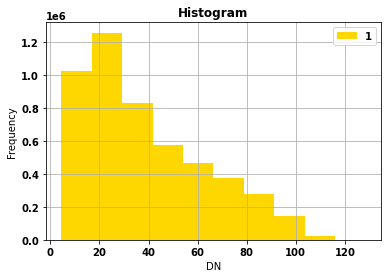

In [140]:
src = rasterio.open(os.path.splitext(BASIN_COG_DICT['biomass_cog_fn'])[0] + "_ESA_trees.tif")
m3 = src.read(3, masked=False)
show_hist(m3) 

# Carbon accumulation

Extent:		3457

Total ha.:		773351.28

Mean AGB Mg/ha in all classes (even water):		84.43
Total AGB Pg. in all classes (even water):	0.0684
Water AGB adds additional 3.1e-05 Pg. to the Total land AGB, an increase of 0.046 %

Mean AGB Mg/ha:		84.43
Total AGB Pg.:		0.0683

Mean AGB Mg/ha in trees:	86.21
Total AGB Pg. in trees:	0.0667
Tree AGB is 0.9757 of Total land AGB

Mean Net C accumulation in trees:	1.29 MgC/ha/yr
Total Pg. C in trees:	0.0008 Pg
Mean Net C accumulation in all classes:	1.3 MgC/ha/yr
Total Pg. C in all classes:	0.0008 Pg
Tree C is 0.9829 of Total land aboveground C

This C proportion doesnt match the AGB proportion due to pixel with stand age = 0
---This doesnt make sense yet --> Adjusted Tree C is 0.901 of Total land aboveground C



(-0.5, 2999.5, 2999.5, -0.5)

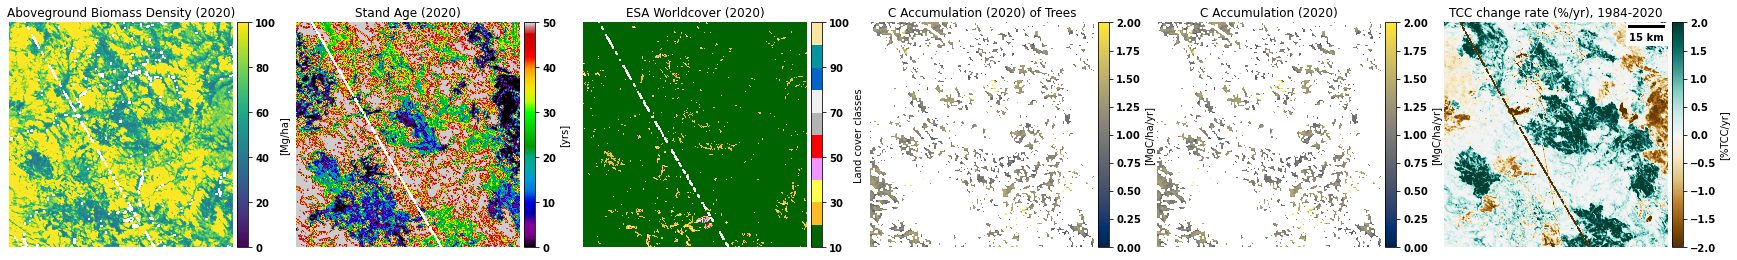

In [157]:
val_lc_nodata, val_lc_trees, val_lc_water = [0, 10, 80]
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(30,30), sharex=True, sharey=True)

# Scalebar doesnt seem correct
scalebar = ScaleBar(30) # <-- each pixel (unit) is 30m
plt.gca().add_artist(scalebar)

standage_arr = rasterio.open(BASIN_COG_DICT['standage_cog_fn']).read(1)
tccslope_arr = rasterio.open(BASIN_COG_DICT['tccslope_cog_fn']).read(1)
tcc2020_arr = rasterio.open(BASIN_COG_DICT['tcc2020_cog_fn']).read(1)

#
# Stand age masked with its nodata
#
standage_arr_masked = np.ma.masked_where( (standage_arr > 100 ) | (standage_arr < 0), standage_arr) # <-- note, leaving in age = 0 here, technically not 'stands'? or just 'recently disturbed stands' - how to get C accumulation when denom is 0?
standage_arr_masked_adj = np.ma.where(standage_arr_masked == 0, 0.5, standage_arr_masked) # <-- instead of age = 0, age = 0.5
standage_arr_masked_trees = np.ma.masked_where( (lc_arr != val_lc_trees  ), standage_arr_masked)
standage_arr_masked_adj_trees = np.ma.masked_where( (lc_arr != val_lc_trees  ), standage_arr_masked_adj)

#
# LC masked with its nodata and water
#
lc_arr_masked = np.ma.masked_where( (lc_arr == val_lc_nodata  ) | (lc_arr == val_lc_water) , lc_arr)

# TCC variables masked with its nodata
tccslope_arr = np.ma.masked_where( (tccslope_arr > 100 ) , tccslope_arr)
tcc2020_arr = np.ma.masked_where( (tcc2020_arr > 100 ) , tcc2020_arr)

# AGB masked with lc nodata
agb_water_arr_masked = np.ma.masked_where( (lc_arr == val_lc_nodata  )  , agb_arr)
# ..and additionally with water
agb_arr_masked = np.ma.masked_where(  (lc_arr == val_lc_water) , agb_water_arr_masked)
# ..and additionally with ESA Worldover trees
agb_arr_masked_trees = np.ma.masked_where( (lc_arr != val_lc_trees  ), agb_arr_masked)

# Carbon accumulation per year (Annual net C accumulation rate)
ratio_c_agb = 0.5
netc_accum_arr = (agb_arr_masked * ratio_c_agb) / standage_arr_masked
netc_accum_arr_adj= (agb_arr_masked * ratio_c_agb) / standage_arr_masked_adj
netc_accum_arr_trees = (agb_arr_masked_trees * ratio_c_agb) / standage_arr_masked
netc_accum_arr_trees_adj = (agb_arr_masked_trees * ratio_c_agb) / standage_arr_masked_adj


# Get the total water AGB
land_water_agb_total = (np.nansum(agb_water_arr_masked)/1e9 * area_pix_ha)
land_agb_total = (np.nansum(agb_arr_masked)/1e9 * area_pix_ha)
water_agb_total = land_water_agb_total - land_agb_total

print(f"Extent:\t\t{TILE_NUM}\n")
print(f"Total ha.:\t\t{(agb_arr_masked_trees[~np.isnan(agb_arr_masked)].count() * area_pix_ha ) }\n")

print(f"Mean AGB Mg/ha in all classes (even water):\t\t{ round(np.nanmean(agb_arr),2) }")
print(f"Total AGB Pg. in all classes (even water):\t{round(np.nansum(agb_arr)/1e9 * area_pix_ha, 4) }")
print(f"Water AGB adds additional { round(water_agb_total, 6)} Pg. to the Total land AGB, an increase of { round(water_agb_total / land_agb_total * 100 , 3) } %\n")

# Land AGB
print(f"Mean AGB Mg/ha:\t\t{ round(np.nanmean(agb_arr_masked),2) }")
print(f"Total AGB Pg.:\t\t{round(np.nansum(agb_arr_masked)/1e9 * area_pix_ha,4) }\n")

# Tree AGB
print(f"Mean AGB Mg/ha in trees:\t{ round(np.nanmean(agb_arr_masked_trees),2) }")
print(f"Total AGB Pg. in trees:\t{round(np.nansum(agb_arr_masked_trees)/1e9 * area_pix_ha, 4) }")
print(f"Tree AGB is {round(  (np.nansum(agb_arr_masked_trees)/1e9 * area_pix_ha) / (np.nansum(agb_arr_masked)/1e9 * area_pix_ha)  , 4) } of Total land AGB\n")

# Carbon accumulation
print(f"Mean Net C accumulation in trees:\t{ round(np.nanmean( netc_accum_arr_trees),2) } MgC/ha/yr")
print(f"Total Pg. C in trees:\t{round(np.nansum(netc_accum_arr_trees)/1e9 * area_pix_ha, 4) } Pg")
print(f"Mean Net C accumulation in all classes:\t{ round(np.nanmean( netc_accum_arr),2) } MgC/ha/yr")
print(f"Total Pg. C in all classes:\t{round(np.nansum(netc_accum_arr)/1e9 * area_pix_ha, 4) } Pg")
print(f"Tree C is {round(  (np.nansum(netc_accum_arr_trees)/1e9 * area_pix_ha) / (np.nansum(netc_accum_arr)/1e9 * area_pix_ha)  , 4) } of Total land aboveground C\n")
print("This C proportion doesnt match the AGB proportion due to pixel with stand age = 0")
print(f"---This doesnt make sense yet --> Adjusted Tree C is {round(  (np.nansum(netc_accum_arr_trees_adj)/1e9 * area_pix_ha) / (np.nansum(netc_accum_arr_adj)/1e9 * area_pix_ha)  , 4) } of Total land aboveground C\n")

# Plots
# Biomass
m1 = axes[0].imshow(agb_arr_masked, clim=(0,100) )
add_colorbar(m1, '[Mg/ha]')
m1 = axes[0].set_title('Aboveground Biomass Density (2020)')
axes[0].axis('off')

# Age
m2 = axes[1].imshow(standage_arr_masked, cmap='nipy_spectral')
add_colorbar(m2, '[yrs]')
axes[1].set_title('Stand Age (2020)')
axes[1].axis('off')

# Showing all LC classes
m3 = axes[2].imshow(lc_arr, cmap=cmap_worldcover, norm=norm_worldcover)
add_colorbar(m3, 'Land cover classes')
axes[2].set_title('ESA Worldcover (2020)')
axes[2].axis('off')

# Carbon accumulation in trees
m4 = axes[3].imshow(netc_accum_arr_trees, clim=(0,2), cmap='cividis')
add_colorbar(m4, '[MgC/ha/yr]')
m4 = axes[3].set_title('C Accumulation (2020) of Trees')
axes[3].axis('off')

# Carbon accumulation in all classes
m5 = axes[4].imshow(netc_accum_arr, clim=(0,2), cmap='cividis')
add_colorbar(m5, '[MgC/ha/yr]')
m5 = axes[4].set_title('C Accumulation (2020)')
axes[4].axis('off')

# TCC trend 1984-2020
m6 = axes[5].imshow(tccslope_arr, clim=(-2,2), cmap='BrBG')
add_colorbar(m6, '[%TCC/yr]')
m6 = axes[5].set_title('TCC change rate (%/yr), 1984-2020')
axes[5].axis('off')

### Stand age, carbon accumulation, and tree cover rate change maps

(-0.5, 2999.5, 2999.5, -0.5)

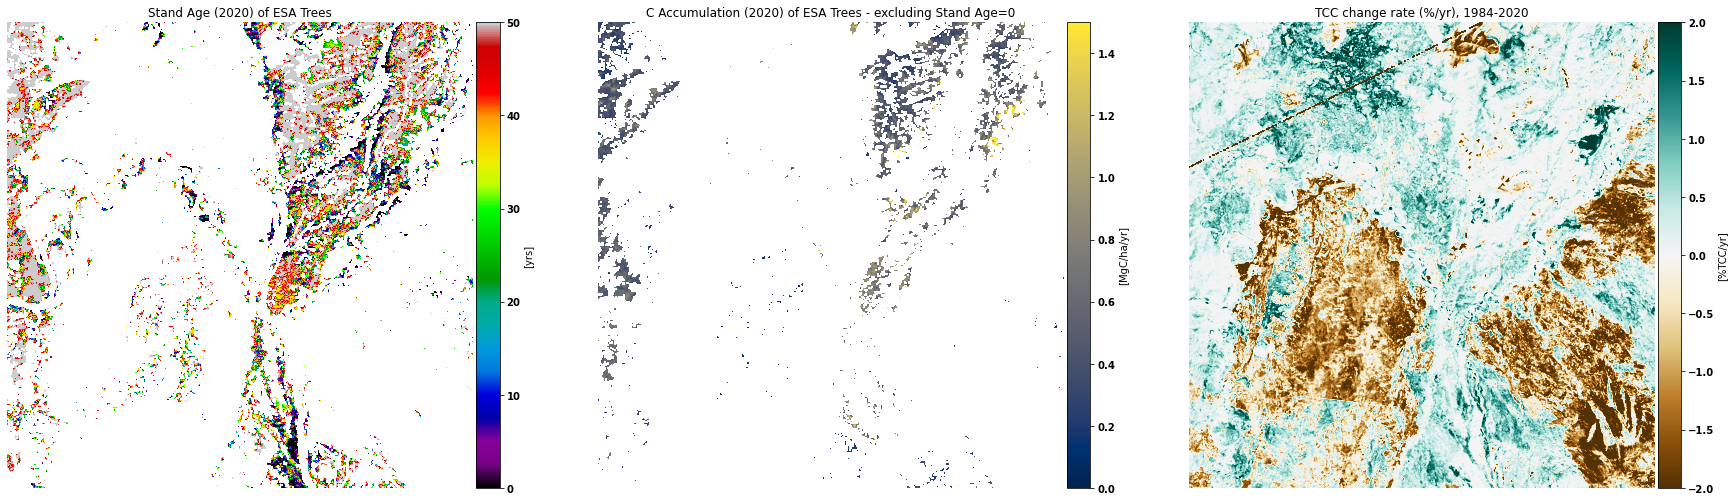

In [142]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,30), sharex=True, sharey=True)

# Age
m2 = axes[0].imshow(standage_arr_masked_trees, cmap='nipy_spectral')
add_colorbar(m2, '[yrs]')
axes[0].set_title('Stand Age (2020) of ESA Trees')
axes[0].axis('off')

# Carbon accumulation
m5 = axes[1].imshow(netc_accum_arr_trees, clim=(0,1.5), cmap='cividis')
add_colorbar(m5, '[MgC/ha/yr]')
m5 = axes[1].set_title('C Accumulation (2020) of ESA Trees - excluding Stand Age=0')
axes[1].axis('off')

# TCC trend 1984-2020
m6 = axes[2].imshow(tccslope_arr, clim=(-2,2), cmap='BrBG')
add_colorbar(m6, '[%TCC/yr]')
m6 = axes[2].set_title('TCC change rate (%/yr), 1984-2020')
axes[2].axis('off')

### Binned scatterplots

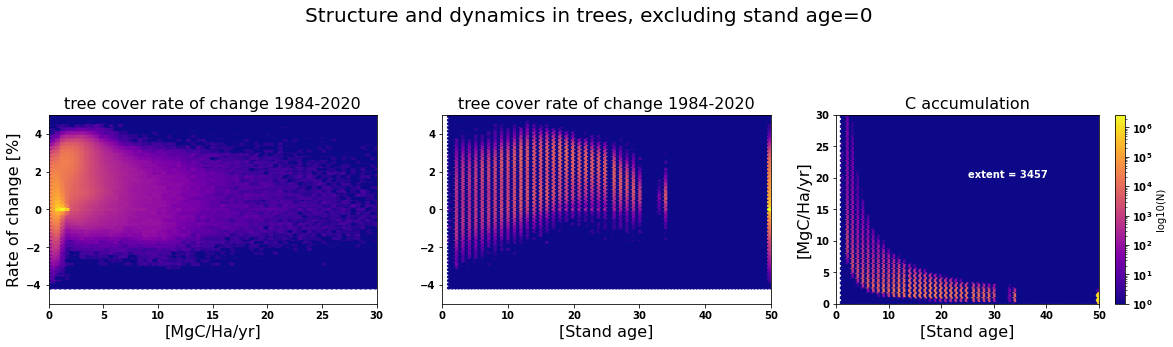

In [166]:
tccslope_masked = np.ma.masked_where(netc_accum_arr_trees.mask, tccslope_arr)

lims_c_accum = [0,30]
lims_stand_age = [0,50]
lims_tcc_change = [-5, 5]

#Declaring the figure, and hiding the ticks' labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
st = fig.suptitle("Structure and dynamics in trees, excluding stand age=0", fontsize=20,  horizontalalignment='center')

## Actually Plotting the data
# Binned scatterplots
ax1.hexbin(np.ravel(netc_accum_arr_trees), np.ravel(tccslope_masked), gridsize=100, bins='log', cmap='plasma')
ax2.hexbin(np.ravel(standage_arr_masked_trees), np.ravel(tccslope_masked), gridsize=100, bins='log', cmap='plasma')
hb3 = ax3.hexbin(np.ravel(standage_arr_masked_trees), np.ravel(netc_accum_arr_trees), gridsize=100, bins='log', cmap='plasma')

# Scatterplots
#ax1.scatter(np.ravel(netc_accum_arr_trees), np.ravel(tccslope_masked),  s=0.1, c='black', alpha=0.01)
#ax2.scatter(np.ravel(standage_arr_masked_trees), np.ravel(tccslope_masked),  s=0.1, c='black', alpha=0.01)
#ax3.scatter(np.ravel(standage_arr_masked_trees), np.ravel(netc_accum_arr_trees),  s=0.1, c='black', alpha=0.01)

#Making the graph pretty and informative!
ax1.set_title("tree cover rate of change 1984-2020", fontsize=16)
ax1.set_ylabel("Rate of change [%]", fontsize=16)
ax1.set_xlabel("[MgC/Ha/yr]", fontsize=16)
ax1.set_ylim(lims_tcc_change)

ax2.set_title("tree cover rate of change 1984-2020", fontsize=16)
ax2.set_xlabel("[Stand age]", fontsize=16)
ax2.set_ylim(lims_tcc_change)

ax3.set_title("C accumulation", fontsize=16)
ax3.set_ylabel("[MgC/Ha/yr]", fontsize=16)
ax3.set_ylim(lims_c_accum)
ax3.set_xlabel("[Stand age]", fontsize=16)
ax3.text(0.5,
         0.67, 
         f"extent = {TILE_NUM}",
         transform=plt.gca().transAxes,
         color = "white"
        )
cb3 = fig.colorbar(hb3, ax=ax3)
cb3.set_label('log10(N)')

# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.65)

ax1.set_xlim(lims_c_accum)
ax2.set_xlim(lims_stand_age)
ax3.set_xlim(lims_stand_age)
plt.show()

# Try this next but need to remove nans from each array: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib

# Stack the masked data and build a dataframe
https://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-output-from-series-to-dataframe

In [144]:
%matplotlib inline

#Return a common mask for a set of input ma
def common_mask(ma_list, apply=False):
    if type(ma_list) is not list:
        print("Input must be list of masked arrays")
        return None
    #Note: a.mask will return single False if all elements are False
    #np.ma.getmaskarray(a) will return full array of False
    #ma_list = [np.ma.array(a, mask=np.ma.getmaskarray(a), shrink=False) for a in ma_list]
    a = np.ma.array(ma_list, shrink=False)
    #Check array dimensions
    #Check dtype = bool
    #Masked values are listed as true, so want to return any()
    #a+b+c - OR (any)
    mask = np.ma.getmaskarray(a).any(axis=0)
    #a*b*c - AND (all)
    #return a.all(axis=0)
    if apply:
        return [np.ma.array(b, mask=mask) for b in ma_list] 
    else:
        return mask

#
# --UPDATE TO A COMMON MASK for the stack
#
arr_list = common_mask([lc_arr_masked, agb_arr_masked, standage_arr_masked, netc_accum_arr, tccslope_arr, tcc2020_arr], apply=True)
#arr_list = [lc_arr_masked, agb_arr_masked, standage_arr_masked, netc_accum_arr, tccslope_arr, tcc2020_arr]

print(arr_list[0].count())
stack = np.stack([arr[(netc_accum_arr>=0) & (tcc2020_arr < 255)].data.flatten() for arr in arr_list],axis=1)

# Common mask
#stack = common_mask(stack, apply=True)

# Build data frame
VARS_LIST = ['LC','Mg_ha', 'Age_yr','Mg_C_ha_yr','TCC_slope','TCC_2020']
stack_df = pd.DataFrame(stack, columns = VARS_LIST)

# Clean
stack_df['Age_yr'] = stack_df['Age_yr'].apply(int)
remap_dict = dict(zip(values_worldcover, names_worldcover))
stack_df['LC'] = stack_df['LC'].replace(remap_dict)
stack_df['LC'] = pd.Categorical(stack_df['LC'], categories=names_worldcover, ordered=True)
stack_df.info()

4840400
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7666329 entries, 0 to 7666328
Data columns (total 6 columns):
 #   Column      Dtype   
---  ------      -----   
 0   LC          category
 1   Mg_ha       float64 
 2   Age_yr      int64   
 3   Mg_C_ha_yr  float64 
 4   TCC_slope   float64 
 5   TCC_2020    float64 
dtypes: category(1), float64(4), int64(1)
memory usage: 299.8 MB


### Histogram of TCC rate of change, 1984-2020

In [76]:
stack_df.head()
# -- get a summary here to check that invalid values are removed

,LC,Mg_ha,Age_yr,Mg_C_ha_yr,TCC_slope,TCC_2020
0,Trees,46.444099,26,0.893156,2.390421,55.0
1,Trees,49.495998,24,1.031167,2.287065,49.0
2,Trees,50.554131,50,0.505541,1.895451,51.0
3,Trees,63.073662,50,0.630737,1.617376,53.0
4,Trees,51.773525,26,0.995645,1.284569,53.0


This will kill the kernel

In [1]:
if False:
    plotnine.options.figure_size = (5, 2)

    # Melt
    stack_df['pix_idx'] = stack_df.index

    stack_df_m = pd.melt(stack_df, id_vars=['pix_idx'], value_vars=VARS_LIST)

    median_tcc_val = stack_df.TCC_slope.median()                  
    print(f"Median TCC change rate, 1984-2020 (% TCC/yr):\t\t{median_tcc_val}")
    print(
        (
            ggplot(aes( x='value', fill='variable'), data=stack_df_m ) 
            + geom_histogram(binwidth=1)
            + geom_vline(xintercept=0, linetype = 'dashed')
            #+ scale_fill_brewer(palette='BrBG', type="diverging")
            #+ coord_cartesian(xlim=(-4,4))
            + facet_grid('variable~.')
            + theme_minimal()
        ) 
    )

# Summarize by land cover
summarize 
+ biomass density
+ carbon accumulation rate

by
+ land cover
+ age

In [ ]:
stack_df_smry = pd.DataFrame(
    stack_df.groupby(["LC","Age_yr"]).agg(
            {
            "Mg_ha": ["sum", "min", "max", "median", "skew", "std", "count"], # np.nansum(netc_accum_arr_trees)/1e9 * area_pix_ha
            "Mg_C_ha_yr": ["min", "max", "median", "skew", "std", "count"]#,
            #"Age_yr": ["min", "max", "median", "skew", "std", "count"]
              }
                        )
    
)
##stack_df_smry['LC'] = stack_df_smry.index
stack_df_smry.index = stack_df_smry.index.set_names(['LC', 'Age'])

stack_df_smry.reset_index(drop=False, inplace=True)

stack_df_smry.columns = [' '.join(col).strip() for col in stack_df_smry.columns.values]

# Convert sum to Pg, normalize sum by area of pixel
stack_df_smry['Total_Pg'] = stack_df_smry['Mg_ha sum']/1e9 * area_pix_ha

stack_df_smry.dropna()


In [ ]:
(
    ggplot(aes( x='Age_yr', fill='LC'), data=stack_df.dropna()[~stack_df['LC'].isin(FILTER_LIST)] ) 
    + geom_bar(stat='count')
    + scale_fill_manual(values=dict(zip(names_worldcover, cols_worldcover)))
    + theme_minimal()
) 

### Total Biomass per land cover class

In [ ]:
FILTER_LIST = ['Open water', 'Barren/sparse', 'Built-up']
KEEP_LIST = ['Trees']
(
    ggplot(aes(y='Total_Pg', x='Age', fill='LC'), data=stack_df_smry.dropna()[~stack_df_smry['LC'].isin(FILTER_LIST)] ) 
    + geom_bar(stat='identity')
    + scale_fill_manual(values=dict(zip(names_worldcover, cols_worldcover)))
    + theme_minimal()
) 

### Carbon accumulation rate

In [ ]:
(
    ggplot(aes(y='Mg_C_ha_yr median', x='Age', fill='LC'), data=stack_df_smry.dropna()[~stack_df_smry['LC'].isin(FILTER_LIST)] ) 
    + geom_bar(stat='identity')
    + scale_fill_manual(values=dict(zip(names_worldcover, cols_worldcover)))
    + facet_grid('LC~.')
    + theme_minimal()
) 

## TCC change rate

In [ ]:
(
    ggplot(aes(y='Mg_C_ha_yr median', x='Age', fill='LC'), data=stack_df_smry.dropna()[~stack_df_smry['LC'].isin(FILTER_LIST)] ) 
    + geom_bar(stat='identity')
    + scale_fill_manual(values=dict(zip(names_worldcover, cols_worldcover)))
    + facet_grid('LC~.')
    + theme_minimal()
)

In [ ]:
p = ggplot(aes(x='Mg_C_ha_yr', fill='LC'), data=df)
p + geom_histogram(binwidth=1)

### Build the VRT of the Worldcover covar data on s3 for the region

In [ ]:
if False:
    for bandnum, bandname in bands_dict.items():

        print(bandnum, bandname)

        # Write a vrt list
        covar_vrt_list = os.path.join(OUTDIR_MAIN, f"cog_tindex.{bandname}.{tile_group_region_string}.txt")

        with open(covar_vrt_list, 'w') as f:

            for text in covar_footprint_tiles_subset['s3_path'].tolist():
                f.write(text.replace("s3:/","/vsis3") + '\n')

        # Make vrt name from text file name
        covar_vrt_fn = covar_vrt_list.replace('.txt','.vrt')

        #get the bbox as part of the gdalbuildvrt and define it, to save time calculating
        extent = [int(b) for b in covar_footprint_tiles_subset.total_bounds]

        extent_str = ' '.join(str(e) for e in extent)

        ###!time gdalbuildvrt -b 1 -te 458521 1503304 5408522 7623304 -input_file_list $vrt_list $vrt_fn
        !time gdalbuildvrt -b $bandnum -te $extent_str -input_file_list $covar_vrt_list $covar_vrt_fn
        print(covar_vrt_fn)

    vrt_fn = '/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt'
    with rasterio.open(vrt_fn) as d:
        print(d.nodatavals)